In [1]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F 
import torch.distributions.laplace as tdl
import torch.distributions.normal as tdn
import torch.distributions.gamma as tdg
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
import warnings
warnings.filterwarnings('ignore')

# set seed for numpy and torch
seed = 769
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
config = {
    'prior_mean' : torch.tensor([0.0]), 
    'gaussian_prior_std' : torch.tensor([5.0]),
    'lap_prior_mean_scale' : torch.tensor([0.25]),
    'lap_prior_var_scale' : torch.tensor([0.5])
}

### Prior ~ N(mean=0, var=25)

In [4]:
prior = tdn.Normal(config['prior_mean'], config['gaussian_prior_std'])

In [5]:
prior.sample((100000,)).shape

torch.Size([100000, 1])

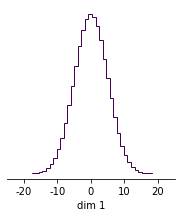

In [6]:
samples = 10000000
samples = prior.sample((samples,))
_ = analysis.pairplot(samples, limits=[[-25,25]], figsize=(3,3))

In [7]:
print("mean of prior : {:.3f}".format(torch.mean(samples).item()))
print("variance of prior : {:.3f}".format(torch.var(samples).item()))

mean of prior : 0.002
variance of prior : 24.999


### Auxiliary Variables

In [8]:
aux1 = tdl.Laplace(config['prior_mean'], config['lap_prior_mean_scale'])
aux2 = tdl.Laplace(config['prior_mean'], config['lap_prior_var_scale'])

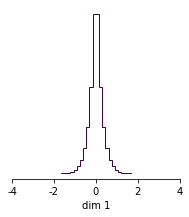

In [9]:
samples = 10000000
samples = aux1.sample((samples,))
_ = analysis.pairplot(samples, limits = [[-4,4]], figsize=(3,3))

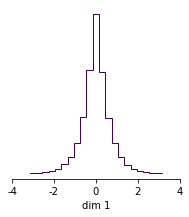

In [10]:
samples = 10000000
samples = aux2.sample((samples,))
_ = analysis.pairplot(samples, limits = [[-4,4]], figsize=(3,3))

### Assumed (wrong) model ~ N(mean=theta, var=1)

In [11]:
def assumed_simulator(theta, std=1, num_iid_samples=50):
    batch_size, num_dims = theta.shape
#     dist = tdn.Normal(theta, std)
    dist = torch.distributions.MultivariateNormal(loc=theta, covariance_matrix=torch.eye(num_dims) * std)
  # should have shape (batch_size, num_dims, num_iid_samples) or similar
    samples = dist.sample((num_iid_samples,))
  # take mean and var over iid dimension.
    mean, var = torch.mean(samples, axis=0), torch.var(samples, axis=0)
    return torch.cat([mean, var], axis=1)

In [13]:
def extended_simulator(theta):
    # Theta is a batch of parameters from the joint prior [Gaussian, Laplace, Laplace]
    # Theta has shape (batch_size, 3)
  
    # Using just the mean parameter from the Gaussian prior.
    # the simulated data x should have shape (batch_size, 2), 
    # with sample mean in first column and sample variance in 2nd
    x = assumed_simulator(theta[:, :1])
    mean = x[:,:1] + theta[:,1:2]
    var = torch.maximum(torch.tensor([0.0]), x[:,1:] + theta[:,2:])
    # return simulated data extended with auxiliary variables, shape (batch_size, 2)
    return torch.cat([mean, var], axis=1)

In [14]:
extended_simulator(torch.ones
                   ([2,3]))

tensor([[1.8801, 1.8964],
        [2.1026, 2.1578]])

In [15]:
assumed_simulator(torch.ones([2,1]))

tensor([[1.1136, 0.7553],
        [0.9546, 0.9452]])

### True model ~ N(mean=theta, var=16) 

#### var to be varied from 1 to 25

In [16]:
def true_simulator(theta, variance=16.0, num_iid_samples=50):
    dist = tdn.Normal(theta, np.sqrt(variance + 4)/3)
    samples = dist.sample((num_iid_samples,))
    mean, var = torch.mean(samples), torch.var(samples)
    return dist, mean, var

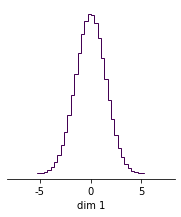

In [17]:
samples = 10000000
samples = true_simulator(torch.tensor([0.0]))[0].sample((samples,))
_ = analysis.pairplot(samples, figsize=(3,3))

In [18]:
print("mean : {:.3f}".format(torch.mean(samples).item()))
print("variance : {:.3f}".format(torch.var(samples).item()))

mean : -0.001
variance : 2.221


### True Posterior Calculations - 1D case

**Likelihood ~ (2/3) N(th0,1.0)+(1/3) N(th0,std^2)  
Prior ~ N(0,25)**

In [19]:
def true_posterior(mean, variance=4.0, num_iid_samples=50):
    l_mean = mean
    l_var = (((2/3)**2)+(variance/9))/num_iid_samples
    p_mean = 0.0
    p_var = 25.0
    mean = (l_var*p_mean + p_var*l_mean) / (l_var + p_var)
    var = 1 / (1/l_var + 1/p_var)
    dist = tdn.Normal(torch.tensor([mean]), torch.tensor([np.sqrt(var)]))
    return dist, mean, var

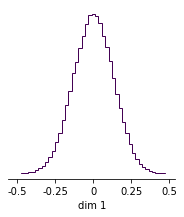

In [20]:
samples = 100000
samples = true_posterior(torch.tensor([0.0]))[0].sample((samples,))
_ = analysis.pairplot(samples, figsize=(3,3))

In [21]:
x0 = true_simulator(torch.tensor([0.0]))[0].sample((1,))
_, mean, var = true_posterior(x0)
print("mean of prior : {:.3f}".format(mean.item()))
print("variance of prior : {:.3f}".format(var))

mean of prior : -0.413
variance of prior : 0.018


### Visualization of training data

In [22]:
simulator_wrapper_unextended, g_prior = prepare_for_sbi(assumed_simulator, prior)

In [23]:
theta1, x1 = simulate_for_sbi(simulator_wrapper_unextended, g_prior, num_simulations=100000)

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

In [24]:
theta1.shape, x1.shape

(torch.Size([100000, 1]), torch.Size([100000, 2]))

In [25]:
inference1 = SNPE(prior=g_prior)

In [26]:
inference1 = inference1.append_simulations(theta1, x1)

In [27]:
density_estimator1 = inference1.train()

Neural network successfully converged after 75 epochs.


In [28]:
posterior1 = inference1.build_posterior(density_estimator1)

In [29]:
prior_list = [prior, aux1, aux2]

In [30]:
simulator_wrapper, comb_prior = prepare_for_sbi(extended_simulator, prior_list)

In [31]:
theta, x = simulate_for_sbi(simulator_wrapper, comb_prior, num_simulations=100000)

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

In [32]:
true_mean_samples = []
true_var_samples = []
points_list = []
i=1
for i in range(10000):
    _, mean, var = true_simulator(prior.sample((1,)), 25.0)
    true_mean_samples.append(mean)
    true_var_samples.append(var)
    points_list.append((i**2 + 4)/9)

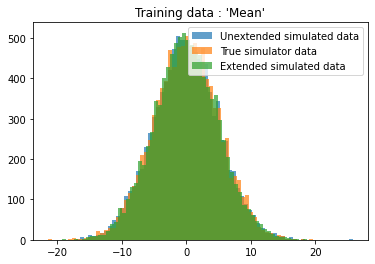

In [33]:
plt.hist(x1[:10000, 0].numpy(), bins="auto", label="mean", alpha=0.7)
plt.hist(np.array(true_mean_samples), bins="auto", label="mean_true_sim", alpha=0.7)
plt.hist(x[:10000, 0].numpy(), bins="auto", label="mean", alpha=0.7)
plt.title("Training data : 'Mean'")
plt.legend(["Unextended simulated data",  "True simulator data","Extended simulated data"])
plt.show()

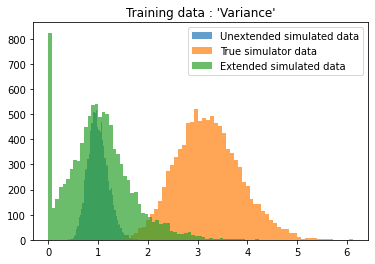

In [34]:
plt.hist(x1[:10000, 1].numpy(), bins="auto", label="var", alpha=0.7)
plt.hist(np.array(true_var_samples), bins="auto", label="mean_true_sim", alpha=0.7)
plt.hist(x[:10000, 1].numpy(), bins="auto", label="var", alpha=0.7)
plt.title("Training data : 'Variance'")
plt.legend(["Unextended simulated data",  "True simulator data","Extended simulated data"])
plt.show()

### Posterior Inference

In [35]:
inference = SNPE(prior=comb_prior)

In [36]:
inference = inference.append_simulations(theta, x)

In [37]:
density_estimator = inference.train()

Neural network successfully converged after 79 epochs.


In [38]:
posterior = inference.build_posterior(density_estimator)

In [39]:
th0 = torch.tensor([[0.0]])
obs_list = []
sample_list = []
# cond_list = []
th_list = []
probs_list = []
var_list = []
true_var_list = []
calc_var_list = []
posterior_mean = []
posterior_var = []
i=1
while i < 5:
    _, mean, var = true_simulator(th0, i**2)
    samples = posterior.sample((10000,), x=[mean, var])
    sample_list.append(samples)
    obs_list.append(mean)
    th_list.append(th0)
    var_list.append(i**2)
    calc_var_list.append((i**2 + 4)/9)
    true_var_list.append(var)
    _, mean, var = true_posterior(mean, i**2)
    posterior_mean.append(mean.item())
    posterior_var.append(var)
    i+=0.1

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [40]:
p_mean = np.array(posterior_mean)

In [41]:
post_mean = np.stack([p_mean, p_mean, p_mean], axis=1)

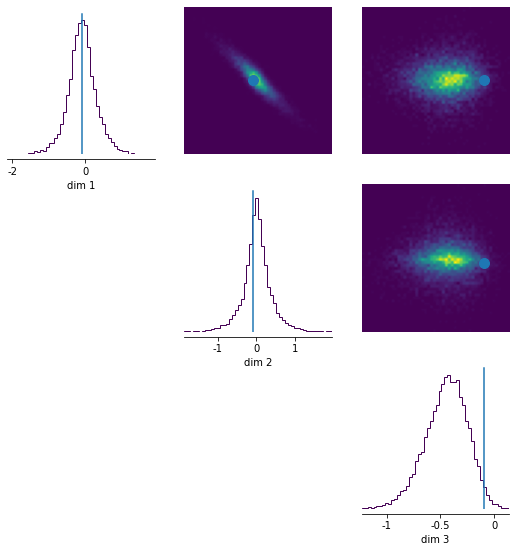

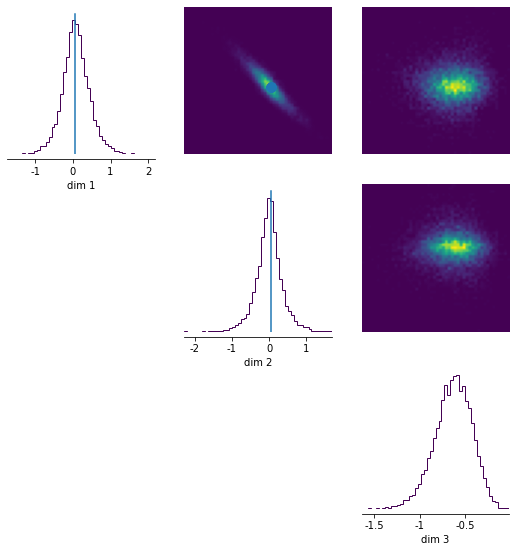

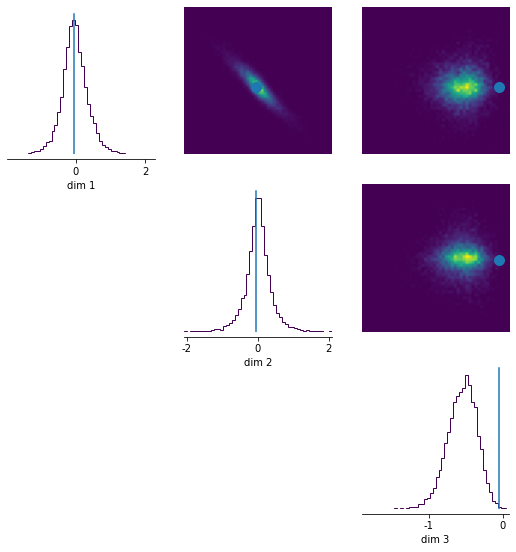

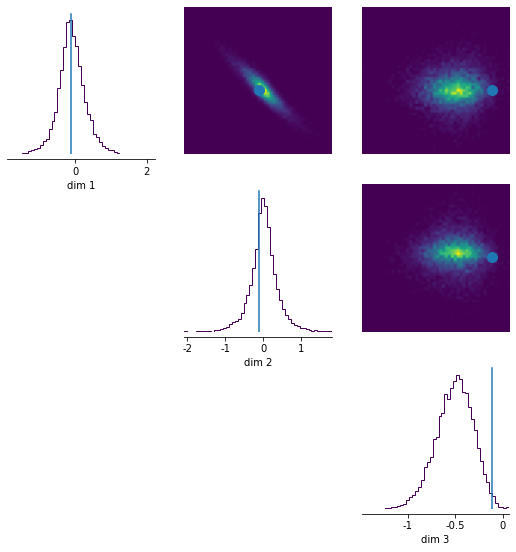

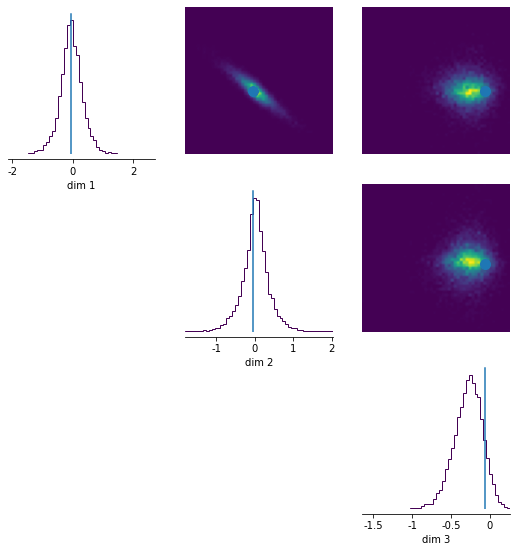

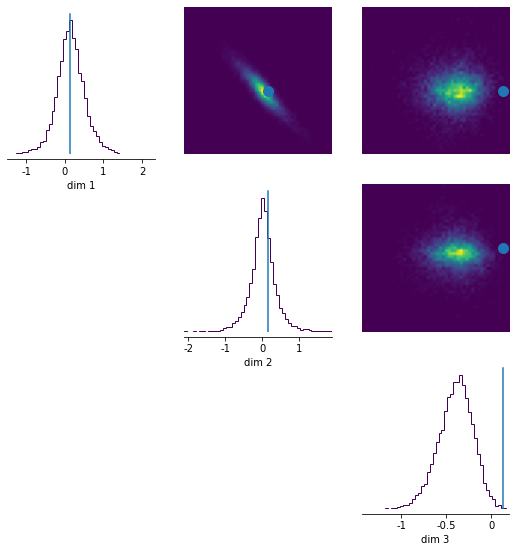

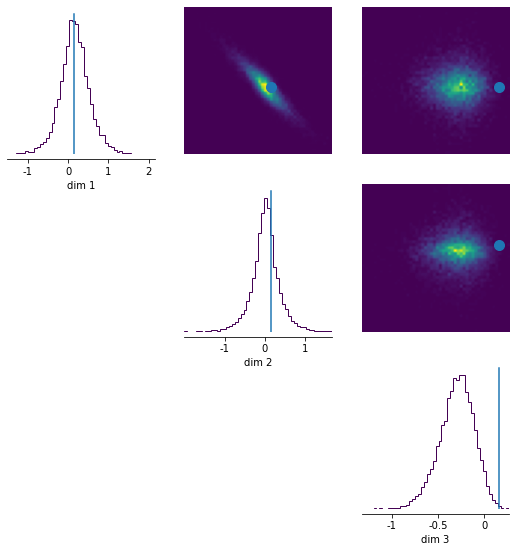

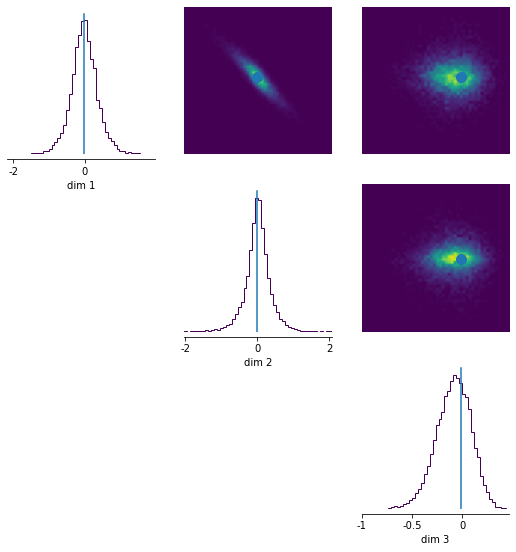

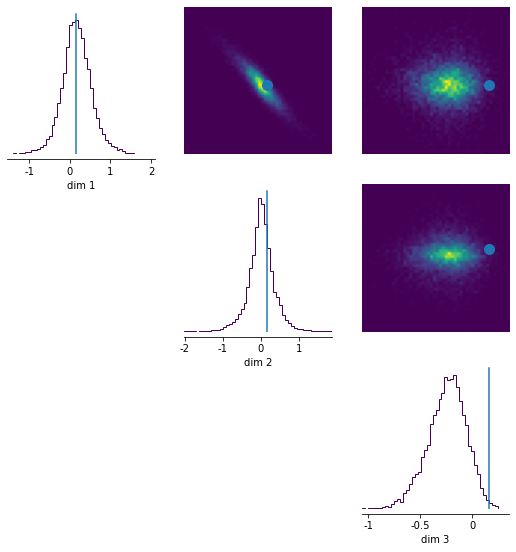

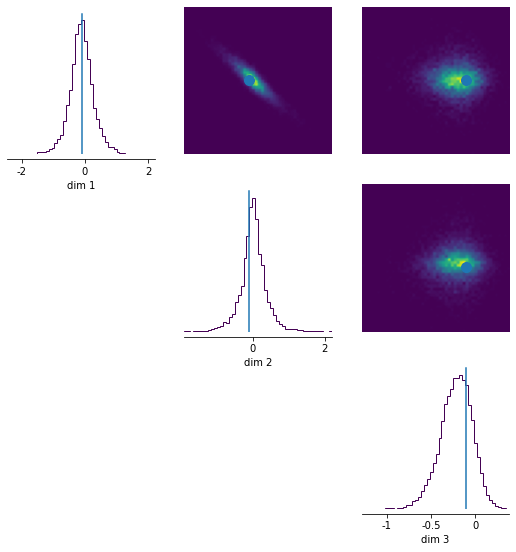

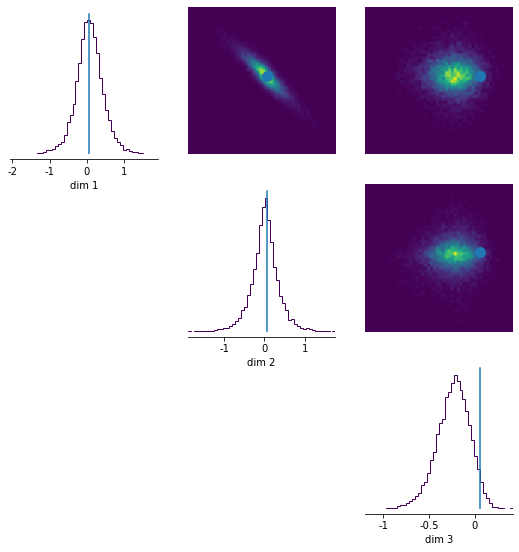

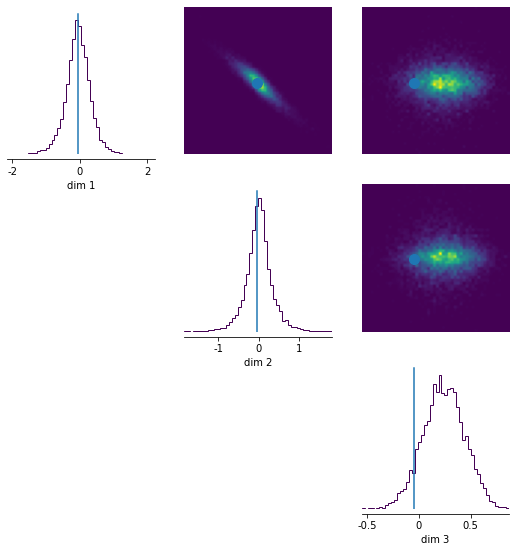

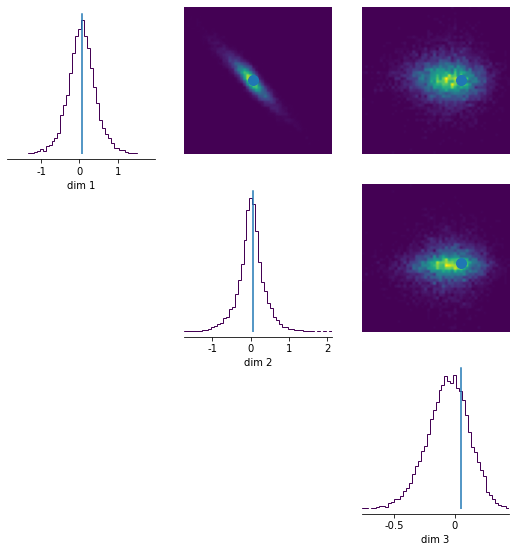

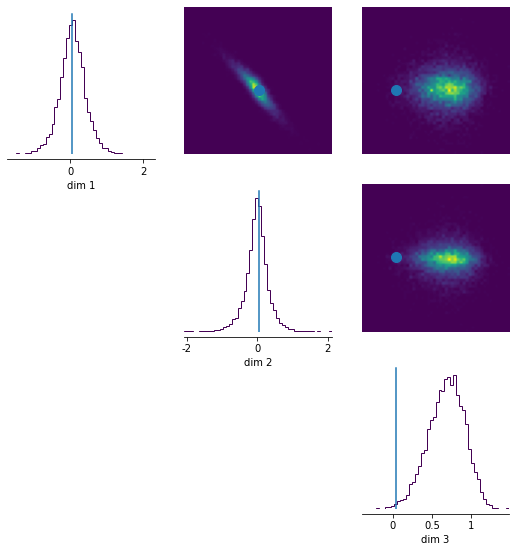

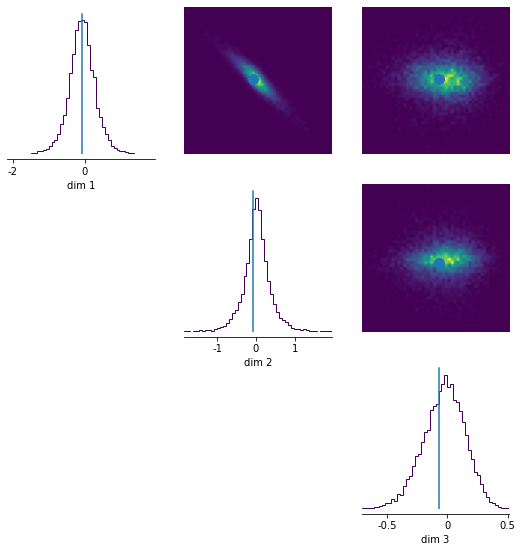

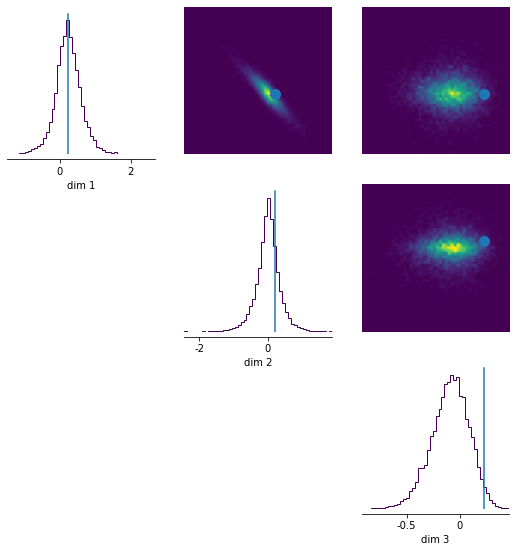

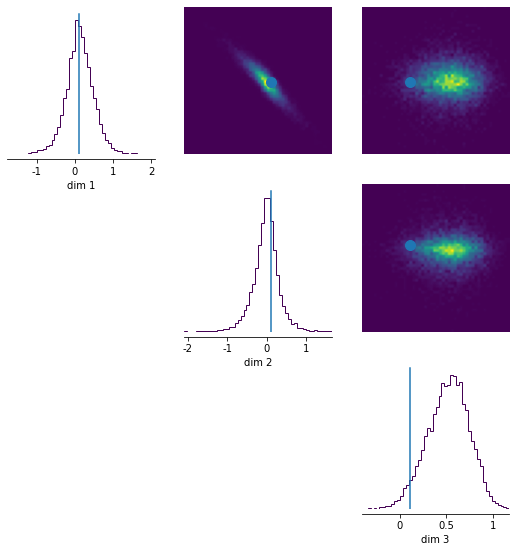

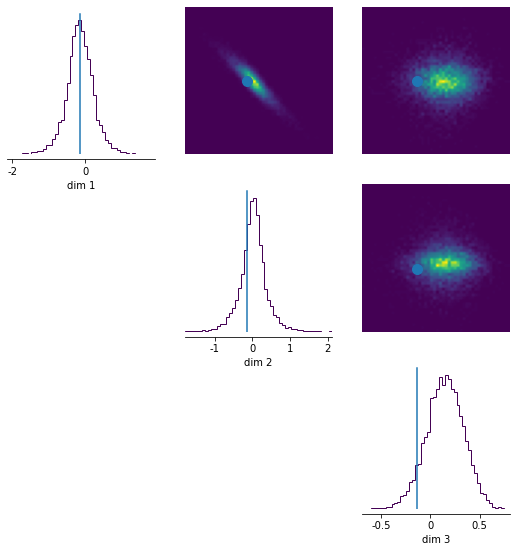

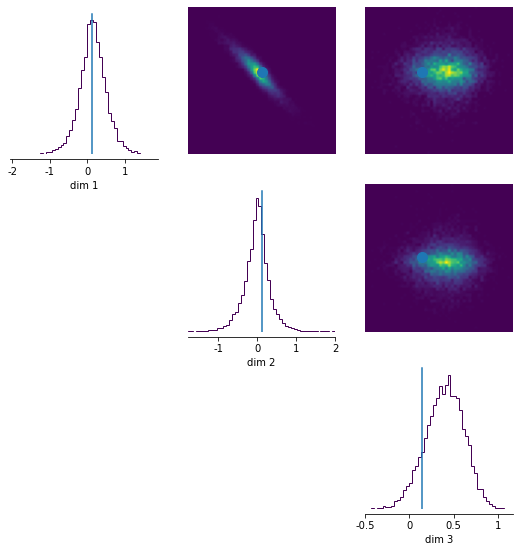

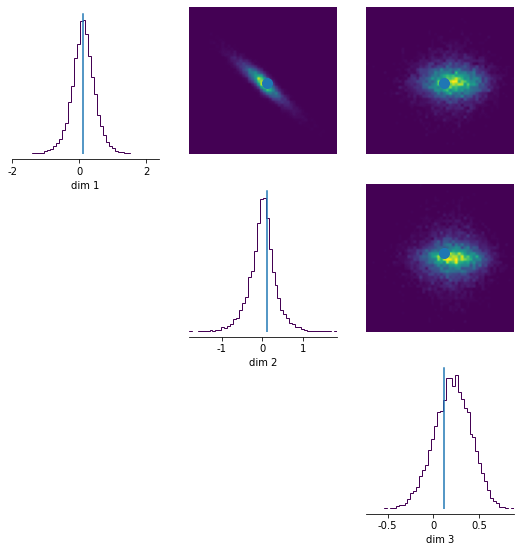

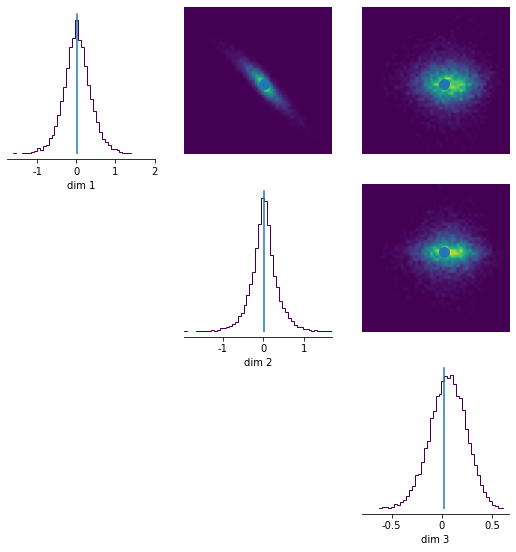

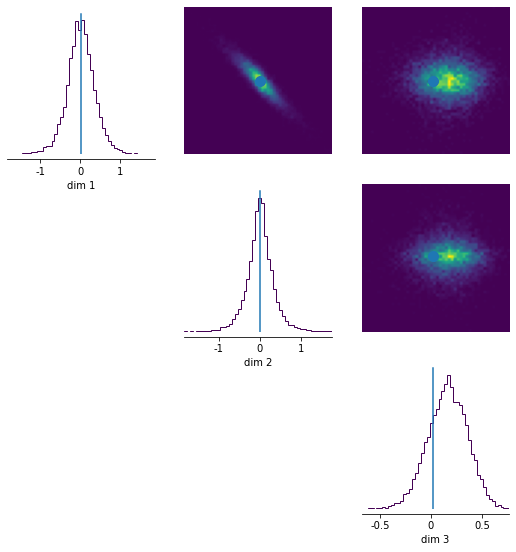

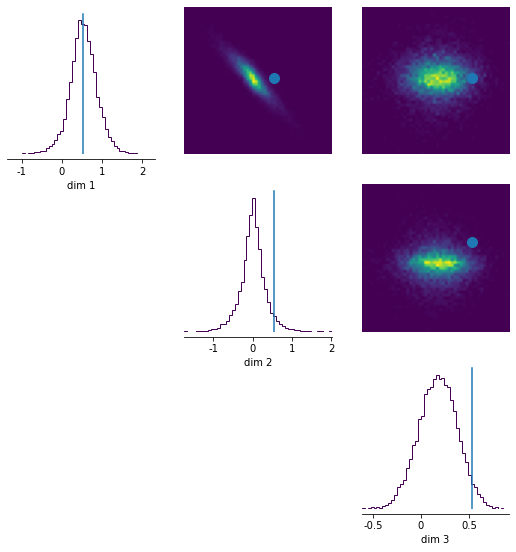

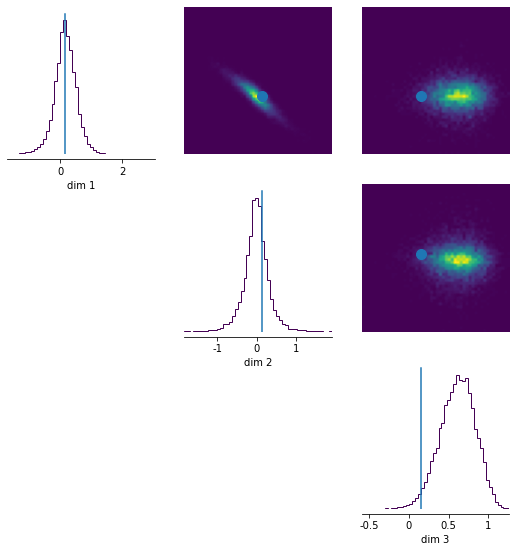

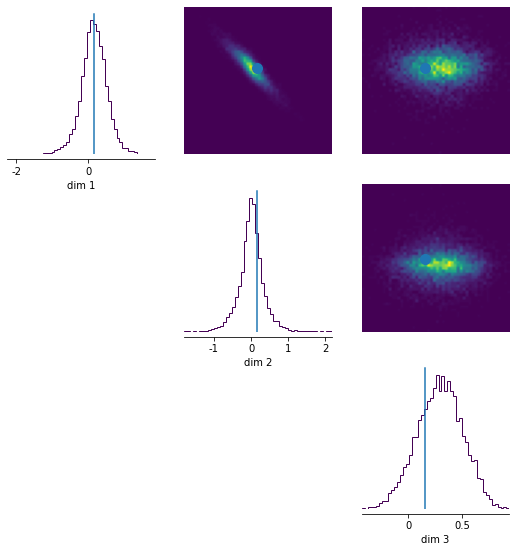

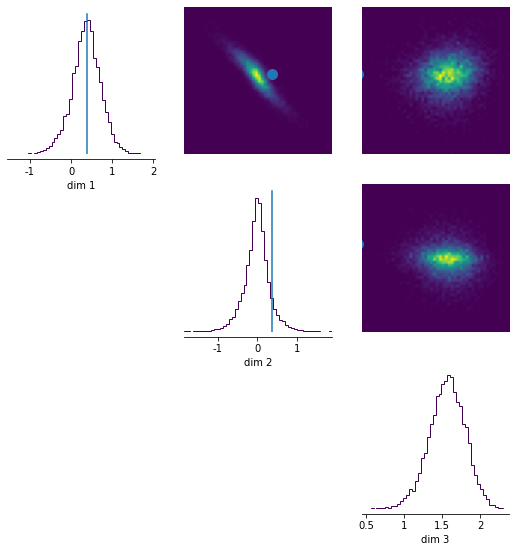

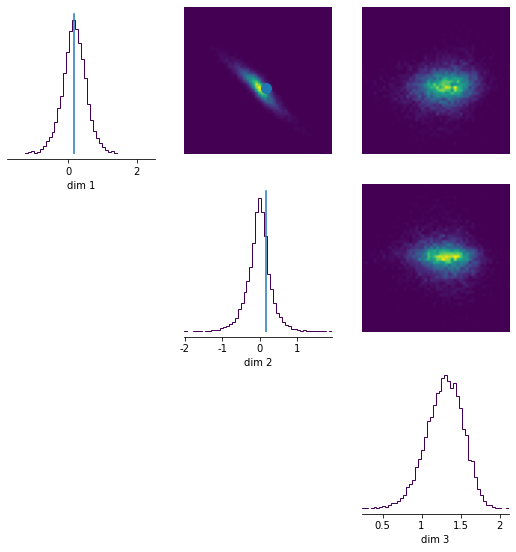

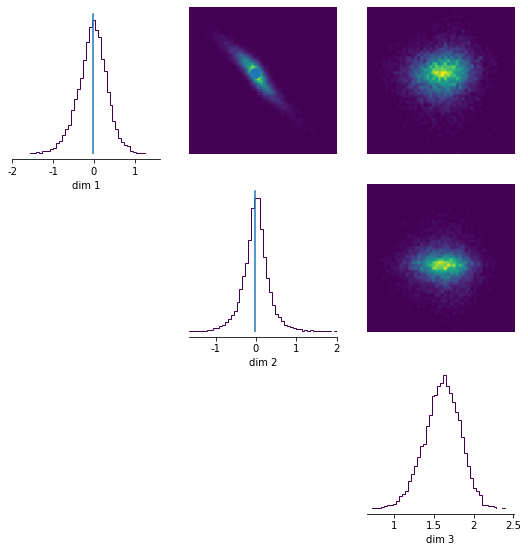

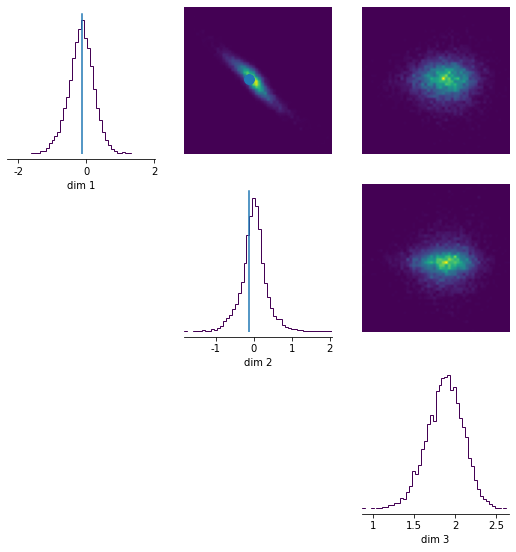

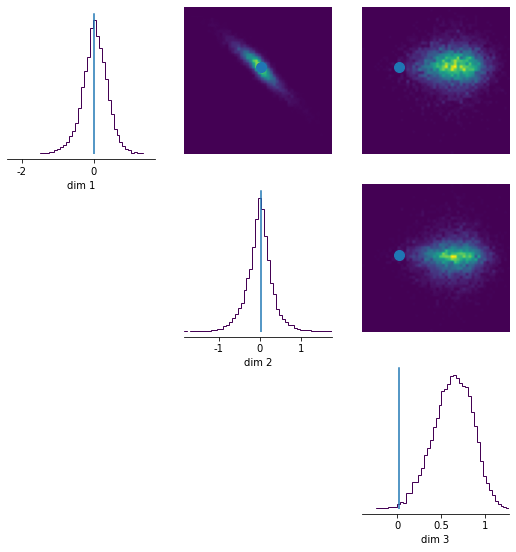

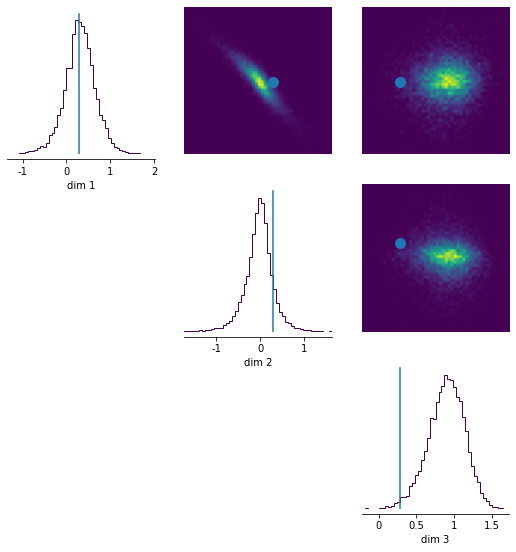

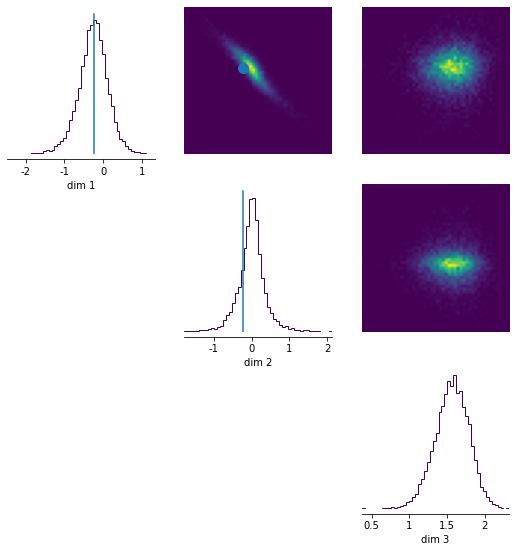

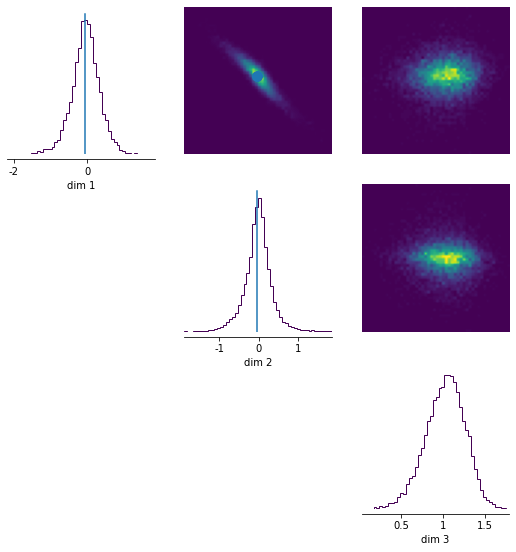

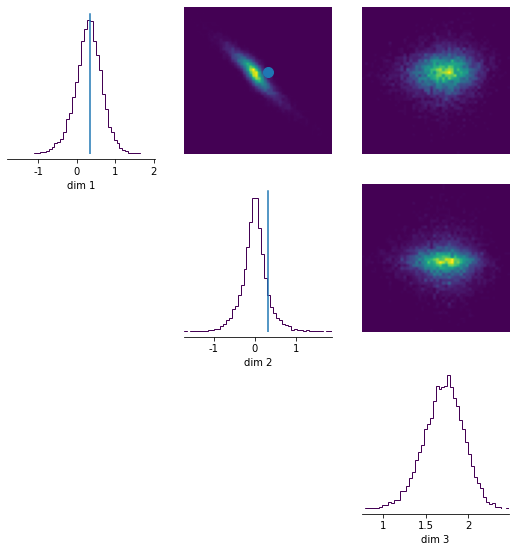

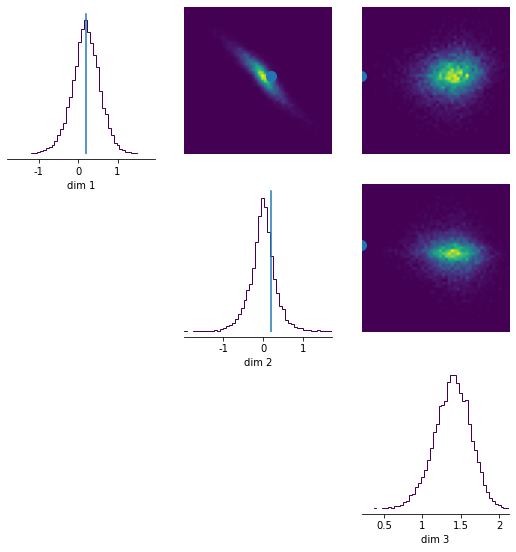

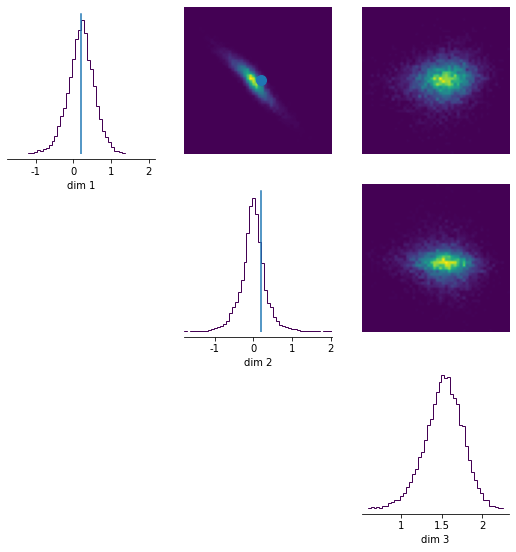

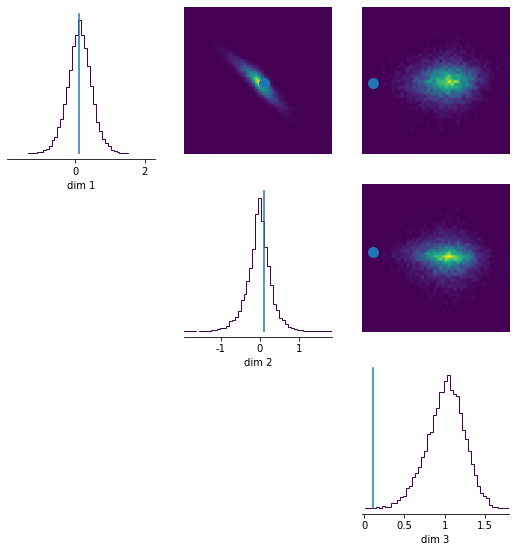

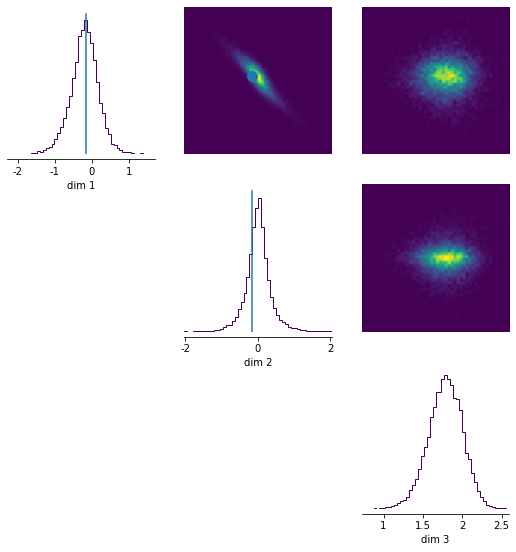

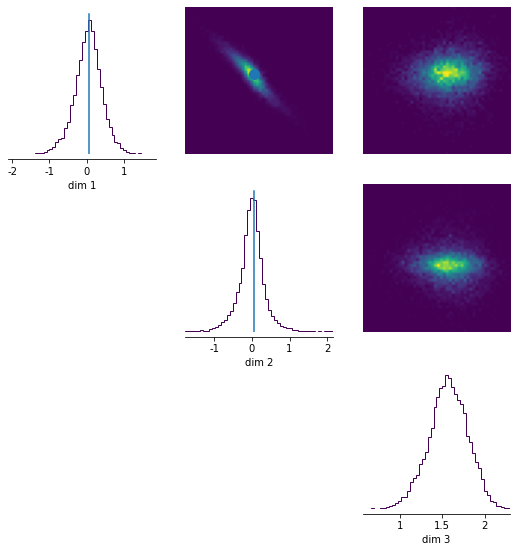

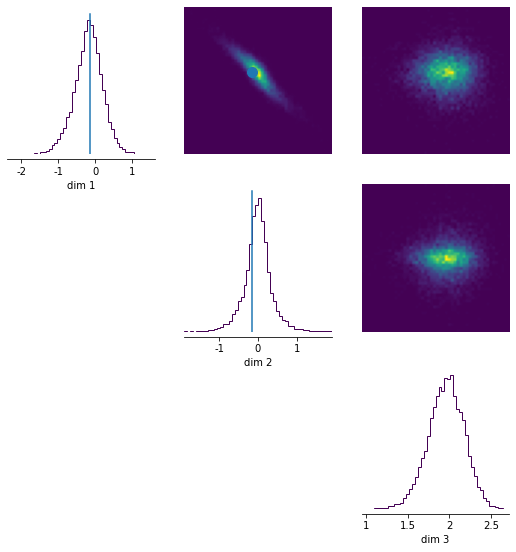

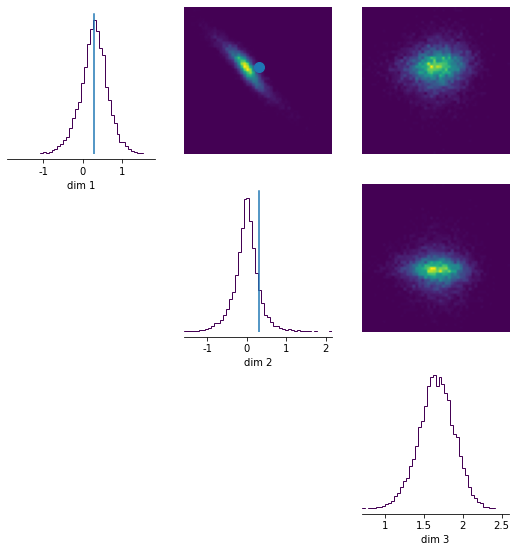

In [42]:
for i in range(len(sample_list)):
    _ = analysis.pairplot(sample_list[i], points=post_mean[i], figsize=(9,9))

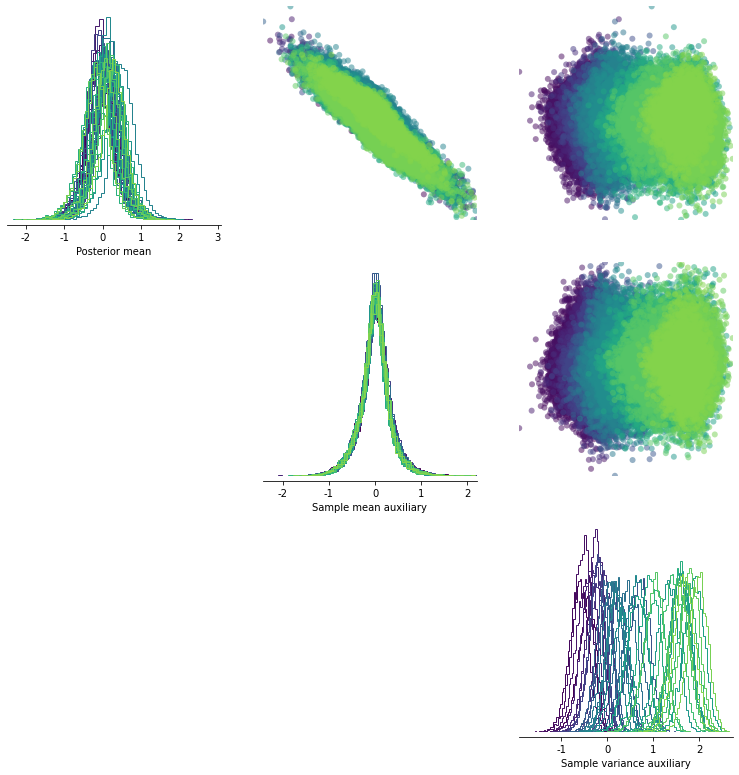

In [130]:
_ = analysis.pairplot(sample_list,upper='scatter', labels=['Posterior mean','Sample mean auxiliary','Sample variance auxiliary'], figsize=(13,13))

In [45]:
sample_mean = np.mean(sample_list, axis=1)
sample_var = np.var(sample_list, axis=1)
g_mean = []
g_var = []
for i in range(len(sample_mean)):
    g_mean.append(sample_mean[i][2]+1)
    g_var.append(sample_var[i][2])

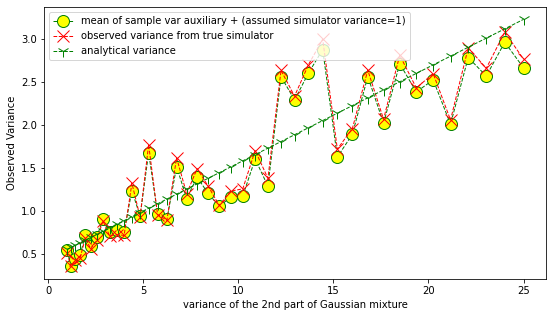

In [46]:
plt.figure(figsize=(9,5))
plt.plot(var_list, g_mean, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='yellow', markersize=12)
plt.plot(var_list,true_var_list, color='red', linestyle='dashed', linewidth = 1,
         marker='x', markerfacecolor='black', markersize=12)
plt.plot(var_list,calc_var_list, color='green', linestyle='dashed', linewidth = 1,
         marker="1",markerfacecolor='black', markersize=12)
plt.xlabel("variance of the 2nd part of Gaussian mixture")
plt.ylabel("Observed Variance")

plt.legend(["mean of sample var auxiliary + (assumed simulator variance=1)", "observed variance from true simulator", "analytical variance"], loc ="upper left")
plt.show()

In [47]:
sample_mean = np.mean(sample_list, axis=1)
sample_var = np.var(sample_list, axis=1)
s_mean = []
s_var = []
for i in range(len(sample_mean)):
    s_mean.append(sample_mean[i][0])
    s_var.append(sample_var[i][0])

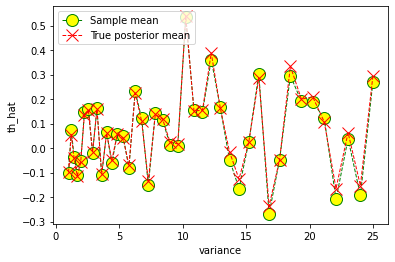

In [48]:
plt.plot(var_list, s_mean, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='yellow', markersize=12)
plt.plot(var_list,posterior_mean, color='red', linestyle='dashed', linewidth = 1,
         marker='x', markerfacecolor='black', markersize=12)
plt.xlabel("variance")
plt.ylabel("th_hat")
plt.legend(["Sample mean", "True posterior mean"], loc ="upper left")
plt.show()

### Posterior Predictive Check

In [121]:
num_sim = 10000
th0 = prior.sample((1,))
_, mean0, var0 = true_simulator(th0, 20.0)
samp1 = posterior1.sample((num_sim,), x=[mean0,var0])
samp2 = posterior.sample((num_sim,), x=[mean0,var0])
samp3 = true_posterior(mean0,20.0)[0].sample((num_sim,))
data1 = assumed_simulator(samp1)
data2 = extended_simulator(samp2)
mean_samples = []
var_samples = []
for param in samp3:
    _, mean, var = true_simulator(param, 20.0)
    mean_samples.append(mean)
    var_samples.append(var)
mean_samples, var_samples = torch.tensor(mean_samples), torch.tensor(var_samples)
mean_samples, var_samples = torch.reshape(mean_samples, (-1,1)), torch.reshape(var_samples, (-1,1))
data3 = torch.cat([mean_samples, var_samples], axis=1)

m_samples = []
v_samples = []
for i in range(10000):
    _, mean, var = true_simulator(th0, 20.0)
    m_samples.append(mean)
    v_samples.append(var)    
m_samples, v_samples = torch.tensor(m_samples), torch.tensor(v_samples)
m_samples, v_samples = torch.reshape(m_samples, (-1,1)), torch.reshape(v_samples, (-1,1))
data4 = torch.cat([m_samples, v_samples], axis=1)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

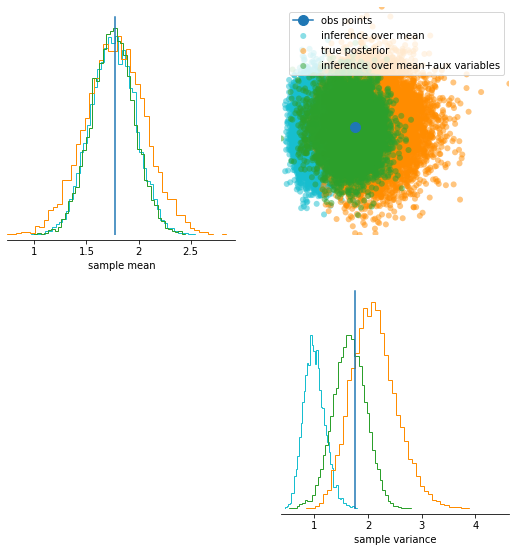

In [132]:
pt = np.stack([mean0, var0])
fig, ax = analysis.pairplot([data1,data3,data2],points=pt, upper='scatter', samples_colors = ['#17becf','#ff8c00','#2ca02c','#e377c2'], labels=['sample mean','sample variance'], figsize=(9,9))
plt.sca(ax[0,1])
plt.legend(["obs points","inference over mean","true posterior","inference over mean+aux variables"],loc='best')

In [124]:
cond_samples = posterior.sample_conditional((10000,), condition=torch.zeros([1,3]), dims_to_sample=[0], x=[mean0, var0]) 
cond_samples_1 = posterior.sample_conditional((10000,), condition=torch.zeros([1,3]), dims_to_sample=[0,2], x=[mean0, var0]) 

Generating samples: 100%|██████████| 10000/10000 [17:45<00:00,  9.38it/s]


In [118]:
ext = torch.zeros([10000,1])
cond_samples_ext = torch.cat([cond_samples_1[:,:1], ext, cond_samples_1[:,1:]], axis=1)
cond_samples_ext

tensor([[10.9498,  0.0000,  0.4372],
        [11.0113,  0.0000,  0.9587],
        [11.0382,  0.0000,  0.5343],
        ...,
        [10.7741,  0.0000,  0.5804],
        [11.0218,  0.0000,  0.7342],
        [10.9279,  0.0000,  0.8428]])

In [125]:
data5 = assumed_simulator(cond_samples)
data6 = extended_simulator(cond_samples_ext)

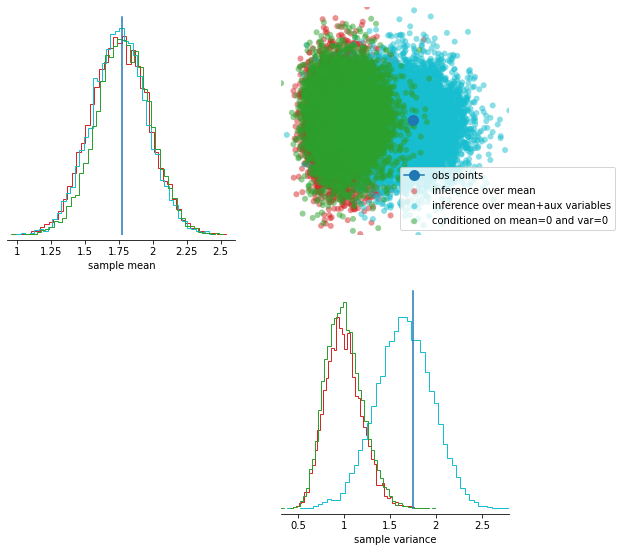

In [127]:
pt = np.stack([mean0, var0])
fig, ax = analysis.pairplot([data1,data2,data5,data6],points=pt, upper='scatter', samples_colors = ['#d62728','#17becf','#2ca02c','#e377c2'], labels=['sample mean','sample variance'], figsize=(9,9))
plt.sca(ax[0,1])
plt.legend(["obs points","inference over mean","inference over mean+aux variables","conditioned on mean=0 and var=0","conditioned on mean=0"],loc="best", bbox_to_anchor=(0.5, 0., 0.5, 0.5))